In [58]:
!pip install replay-rec --quiet
!pip install rs_datasets

In [1]:
import os
import sys

os.environ['PYTHONPATH'] = ""
sys.path.remove('/home/jovyan/.imgenv-vasilyev-0/lib/python3.7/site-packages')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
# from rs_datasets import MovieLens
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [3]:
ml = MovieLens('1m')
data = ml.ratings
data['timestamp'] = data['timestamp'].map(lambda x: datetime.fromtimestamp(x))
data

,user_id,item_id,rating,timestamp
0,0,2757,4,2001-01-01 01:00:19
1,0,1068,5,2001-01-01 01:00:55
2,0,1444,4,2001-01-01 01:00:55
3,0,861,5,2001-01-01 01:00:55
4,0,1978,3,2001-01-01 01:01:43
...,...,...,...,...
999606,6039,2512,4,2001-08-10 18:40:29
999607,6039,1590,4,2001-08-10 18:41:04
999608,6039,1485,3,2001-08-10 18:41:04
999609,6039,145,3,2001-08-10 18:41:26


### EDA

In [4]:
count_user_interaction = data.groupby('user_id')['item_id'].count()
count_item_interaction = data.groupby('item_id')['user_id'].count()

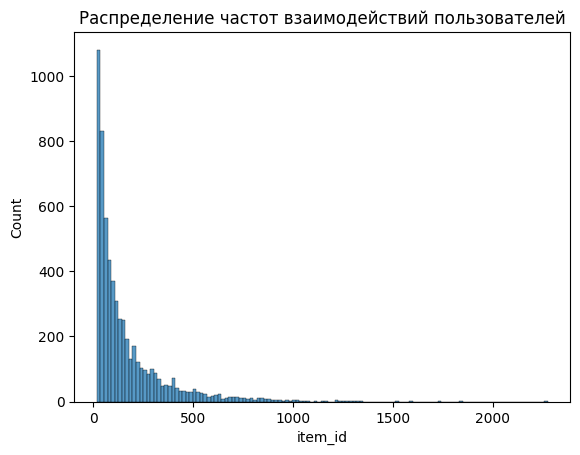

In [10]:
sns.histplot(count_user_interaction)
plt.title('Распределение частот взаимодействий пользователей')
plt.show()

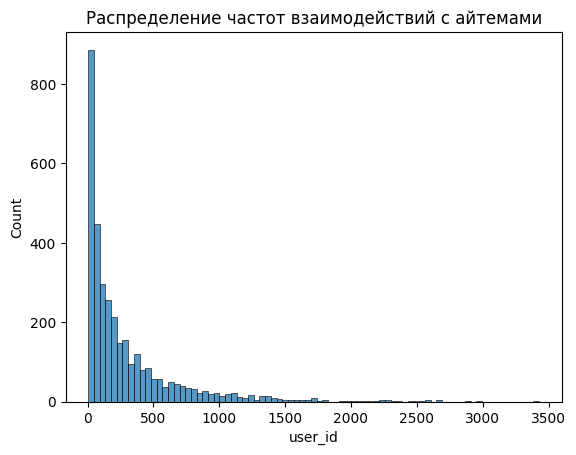

In [11]:
sns.histplot(count_item_interaction)
plt.title('Распределение частот взаимодействий с айтемами')
plt.show()

In [12]:
stats = pd.Series()
stats['all_events'] = data.shape[0]
stats['all_user'] = data['user_id'].nunique()
stats['all_items'] = data['item_id'].nunique()
stats['mean_length'] = np.mean(data.groupby('user_id').count()['timestamp'])
stats['density'] = stats['all_events'] / (stats['all_items'] * stats['all_user'])

In [13]:
print(f"Количество взаимодействий: {int(stats['all_events'])}")
print(f"Количество уникальных пользователей: {int(stats['all_user'])}")
print(f"Количество уникальных айтемов: {int(stats['all_items'])}")
print(f"Средняя длина последовательности взаимодействий: {int(stats['mean_length'])}")
print(f"Плотность данных: {round(stats['density'],3)}")

Количество взаимодействий: 999611
Количество уникальных пользователей: 6040
Количество уникальных айтемов: 3416
Средняя длина последовательности взаимодействий: 165
Плотность данных: 0.048


<Axes: >

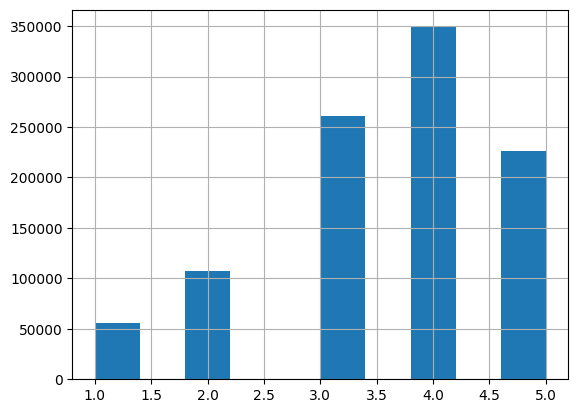

In [14]:
data['rating'].hist()

### Фильтрация данных

In [15]:
def drop_duplicates_items(data, user_id='user_id', item_id='item_id', timestamp='timestamp'):
    """Удаление повторяющихся айтемов в последовательности юзера вида i-i-j -> i-j."""

    data.sort_values([user_id, timestamp], inplace=True)
    data['user_item'] = data[user_id].astype(str) + '_' + data[item_id].astype(str)

    while (data['user_item'].shift() == data['user_item']).sum() != 0:
        not_duplicates_ind = data['user_item'].shift() != data['user_item']
        data = data.loc[not_duplicates_ind]

    data = data.drop('user_item', axis=1)

    return data

def filter_items(data, item_min_count, item_id='item_id'):
    """Фильтрация айтемов с малым количеством взаимодействий."""

    counts = data[item_id].value_counts()
    data = data[data[item_id].isin(counts[counts >= item_min_count].index)]

    return data

def filter_users(data, user_min_count, user_id='user_id'):
    """Фильтрация юзеров с малым количеством взаимодействий."""

    counts = data[user_id].value_counts()
    data = data[data[user_id].isin(counts[counts >= user_min_count].index)]

    return data

In [16]:
print('Количество взаимодействий в сырых данных = {}'.format(len(data)))

Количество взаимодействий в сырых данных = 999611


In [17]:
data = filter_items(data, item_min_count=20, item_id='item_id')
print('Количество взаимодействий после фильтрации айтемов = {}'.format(len(data)))

Количество взаимодействий после фильтрации айтемов = 995492


In [18]:
data = filter_users(data, user_min_count=20, user_id='user_id')
print('Количество взаимодействий после фильтрации пользователей = {}'.format(len(data)))

Количество взаимодействий после фильтрации пользователей = 995154


In [19]:
data = drop_duplicates_items(data=data, user_id='user_id', item_id='item_id', timestamp='timestamp')
print('Количество взаимодействий в после удаления дубликатов = {}'.format(len(data)))

Количество взаимодействий в после удаления дубликатов = 995154


In [20]:
print('Количество взаимодействий = {}'.format(len(data)))
print('Количество юзеров = {}'.format(len(data.user_id.unique())))
print('Количество айтемов = {}'.format(len(data.item_id.unique())))

Количество взаимодействий = 995154
Количество юзеров = 6022
Количество айтемов = 3043


Релизация Replay

In [21]:
from replay.preprocessing.filters import NumInteractionsFilter
from replay.preprocessing.filters import LowRatingFilter
from replay.preprocessing.filters import MinCountFilter


libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [22]:
ml = MovieLens('1m')
data = ml.ratings
data["timestamp"] = data['timestamp'].map(lambda x: datetime.fromtimestamp(x))
data.head()

,user_id,item_id,rating,timestamp
0,0,2757,4,2001-01-01 01:00:19
1,0,1068,5,2001-01-01 01:00:55
2,0,1444,4,2001-01-01 01:00:55
3,0,861,5,2001-01-01 01:00:55
4,0,1978,3,2001-01-01 01:01:43


In [23]:
print('Количество взаимодействий в сырых данных = {}'.format(len(data)))

Количество взаимодействий в сырых данных = 999611


In [24]:
# Берем в каждой последовательности пользователя последние 128 айтемов
data = NumInteractionsFilter(num_interactions=128).transform(data)
print('Количество взаимодействий после фильтрации по длине последовательности = {}'.format(len(data)))

Количество взаимодействий после фильтрации по длине последовательности = 521171


In [25]:
# Оставляем последовательности с рейтингом 3 или выше
data = LowRatingFilter(value=3).transform(data)
print('Количество взаимодействий после фильтрации по оценкам = {}'.format(len(data)))

Количество взаимодействий после фильтрации по оценкам = 451906


In [26]:
# Оставляем пользователей с не менее 5 взаимодействиями
data = MinCountFilter(num_entries=5, groupby_column='user_id').transform(data)
print('Количество взаимодействий после фильтрации по пользователям = {}'.format(len(data)))

Количество взаимодействий после фильтрации по пользователям = 451905


In [27]:
# Оставляем айтемы с не менее 5 взаимодействиями
data = MinCountFilter(num_entries=5, groupby_column='item_id').transform(data)
print('Количество взаимодействий после фильтрации по айтемам = {}'.format(len(data)))

Количество взаимодействий после фильтрации по айтемам = 450908


In [28]:
print('Количество взаимодействий = {}'.format(len(data)))
print('Количество юзеров = {}'.format(len(data.user_id.unique())))
print('Количество айтемов = {}'.format(len(data.item_id.unique())))

Количество взаимодействий = 450908
Количество юзеров = 6038
Количество айтемов = 2965


### Разбиение данных

Основные параметры для сплиттеров в RePlay\
query_column (str): Название колонки пользователя \
drop_cold_users (bool): Удалить пользователей из test датасета, которых нет в train датасете \
drop_cold_items (bool): Удалить айтемы из test датасета, которых нет в train \



#### Случайное разбиение

In [29]:
data.sort_values(['user_id', 'timestamp'], inplace=True)

In [30]:
from replay.splitters.random_splitter import RandomSplitter
train, test = RandomSplitter(test_size=0.3,
                             drop_cold_items=True,
                             drop_cold_users=True,
                             seed=32, query_column='user_id').split(data)

In [31]:
print('Количество взаимодействий в train= {}'.format(len(train)))
print('Количество юзеров в train = {}'.format(len(train.user_id.unique())))
print('Количество айтемов в train = {}'.format(len(train.item_id.unique())))

Количество взаимодействий в train= 315636
Количество юзеров в train = 6038
Количество айтемов в train = 2964


In [32]:
print('Количество взаимодействий в test= {}'.format(len(test)))
print('Количество юзеров в test = {}'.format(len(test.user_id.unique())))
print('Количество айтемов в test = {}'.format(len(test.item_id.unique())))

Количество взаимодействий в test= 135267
Количество юзеров в test = 6037
Количество айтемов в test = 2927


In [33]:
print('Взаимодействия пользователя до разбиения данных')
data[data.user_id == 4349]

Взаимодействия пользователя до разбиения данных


,user_id,item_id,rating,timestamp
726677,4349,998,5,2000-08-02 11:32:44
726678,4349,241,4,2000-08-02 11:33:09
726679,4349,547,3,2000-08-02 11:33:27
726680,4349,1010,5,2000-08-02 11:33:49
726681,4349,105,5,2000-08-02 11:34:06
...,...,...,...,...
726743,4349,2512,5,2000-11-25 11:30:10
726744,4349,423,3,2000-11-25 11:30:10
726745,4349,2178,3,2000-11-25 11:30:59
726746,4349,353,4,2000-11-25 11:31:27


In [34]:
print('Взаимодействия пользователя в train')
train[train.user_id == 4349].sort_values('timestamp')

Взаимодействия пользователя в train


,user_id,item_id,rating,timestamp
726681,4349,105,5,2000-08-02 11:34:06
726682,4349,3241,3,2000-08-02 11:35:51
726683,4349,3308,3,2000-08-02 11:36:22
726686,4349,2277,4,2000-08-02 11:40:04
726685,4349,996,5,2000-08-02 11:40:04
726684,4349,2983,4,2000-08-02 11:40:04
726687,4349,1006,5,2000-08-02 11:41:47
726689,4349,506,4,2000-08-02 11:41:47
726691,4349,1590,3,2000-08-02 11:42:08
726692,4349,926,5,2000-08-02 11:42:35


In [35]:
print('\n Взаимодействия пользователя в test')
test[test.user_id == 4349]


 Взаимодействия пользователя в test


,user_id,item_id,rating,timestamp
726677,4349,998,5,2000-08-02 11:32:44
726678,4349,241,4,2000-08-02 11:33:09
726679,4349,547,3,2000-08-02 11:33:27
726680,4349,1010,5,2000-08-02 11:33:49
726688,4349,1068,4,2000-08-02 11:41:47
726690,4349,546,4,2000-08-02 11:42:08
726694,4349,2241,5,2000-08-02 11:43:55
726707,4349,2451,3,2000-08-02 11:47:03
726717,4349,3163,3,2000-08-19 10:18:10
726724,4349,407,3,2000-08-19 10:27:53


### Разбиение по времени.

In [42]:
from replay.splitters.time_splitter import TimeSplitter
train, test = TimeSplitter(time_threshold='2000-11-25 11:30:10',
                           drop_cold_items=True,
                           drop_cold_users=True, query_column='user_id').split(data)

In [43]:
print('Количество взаимодействий в train= {}'.format(len(train)))
print('Количество юзеров в train = {}'.format(len(train.user_id.unique())))
print('Количество айтемов в train = {}'.format(len(train.item_id.unique())))

Количество взаимодействий в train= 362701
Количество юзеров в train = 5082
Количество айтемов в train = 2965


In [44]:
print('Количество взаимодействий в test= {}'.format(len(test)))
print('Количество юзеров в test = {}'.format(len(test.user_id.unique())))
print('Количество айтемов в test = {}'.format(len(test.item_id.unique())))

Количество взаимодействий в test= 18204
Количество юзеров в test = 544
Количество айтемов в test = 2166


In [45]:
print('Взаимодействия пользователя до разбиения данных')
data[data.user_id == 4349]

Взаимодействия пользователя до разбиения данных


,user_id,item_id,rating,timestamp
726677,4349,998,5,2000-08-02 11:32:44
726678,4349,241,4,2000-08-02 11:33:09
726679,4349,547,3,2000-08-02 11:33:27
726680,4349,1010,5,2000-08-02 11:33:49
726681,4349,105,5,2000-08-02 11:34:06
...,...,...,...,...
726743,4349,2512,5,2000-11-25 11:30:10
726744,4349,423,3,2000-11-25 11:30:10
726745,4349,2178,3,2000-11-25 11:30:59
726746,4349,353,4,2000-11-25 11:31:27


In [46]:
print('Взаимодействия пользователя в train')
train[train.user_id == 4349]

Взаимодействия пользователя в train


,user_id,item_id,rating,timestamp
726677,4349,998,5,2000-08-02 11:32:44
726678,4349,241,4,2000-08-02 11:33:09
726679,4349,547,3,2000-08-02 11:33:27
726680,4349,1010,5,2000-08-02 11:33:49
726681,4349,105,5,2000-08-02 11:34:06
...,...,...,...,...
726738,4349,502,5,2000-11-25 11:25:40
726739,4349,2309,3,2000-11-25 11:27:13
726740,4349,563,4,2000-11-25 11:27:42
726741,4349,1188,3,2000-11-25 11:28:02


In [47]:
print('\n Взаимодействия пользователя в test')
test[test.user_id == 4349]


 Взаимодействия пользователя в test


,user_id,item_id,rating,timestamp
726743,4349,2512,5,2000-11-25 11:30:10
726744,4349,423,3,2000-11-25 11:30:10
726745,4349,2178,3,2000-11-25 11:30:59
726746,4349,353,4,2000-11-25 11:31:27
726747,4349,3189,5,2000-11-25 11:31:54


#### Last N splitter

In [48]:
from replay.splitters.last_n_splitter import LastNSplitter
train, test = LastNSplitter(N=2,
                            drop_cold_items=True,
                            drop_cold_users=True,
                            divide_column="user_id",
                            query_column='user_id').split(data)

In [49]:
print('Количество взаимодействий в train= {}'.format(len(train)))
print('Количество юзеров в train = {}'.format(len(train.user_id.unique())))
print('Количество айтемов в train = {}'.format(len(train.item_id.unique())))

Количество взаимодействий в train= 438832
Количество юзеров в train = 6038
Количество айтемов в train = 2965


In [50]:
print('Количество взаимодействий в test= {}'.format(len(test)))
print('Количество юзеров в test = {}'.format(len(test.user_id.unique())))
print('Количество айтемов в test = {}'.format(len(test.item_id.unique())))

Количество взаимодействий в test= 12076
Количество юзеров в test = 6038
Количество айтемов в test = 2154


In [51]:
print('Взаимодействия пользователя до разбиения данных')
data[data.user_id == 4349]

Взаимодействия пользователя до разбиения данных


,user_id,item_id,rating,timestamp
726677,4349,998,5,2000-08-02 11:32:44
726678,4349,241,4,2000-08-02 11:33:09
726679,4349,547,3,2000-08-02 11:33:27
726680,4349,1010,5,2000-08-02 11:33:49
726681,4349,105,5,2000-08-02 11:34:06
...,...,...,...,...
726743,4349,2512,5,2000-11-25 11:30:10
726744,4349,423,3,2000-11-25 11:30:10
726745,4349,2178,3,2000-11-25 11:30:59
726746,4349,353,4,2000-11-25 11:31:27


In [52]:
print('Взаимодействия пользователя в train')
train[train.user_id == 4349]

Взаимодействия пользователя в train


,user_id,item_id,rating,timestamp
726677,4349,998,5,2000-08-02 11:32:44
726678,4349,241,4,2000-08-02 11:33:09
726679,4349,547,3,2000-08-02 11:33:27
726680,4349,1010,5,2000-08-02 11:33:49
726681,4349,105,5,2000-08-02 11:34:06
...,...,...,...,...
726741,4349,1188,3,2000-11-25 11:28:02
726742,4349,1000,5,2000-11-25 11:29:26
726743,4349,2512,5,2000-11-25 11:30:10
726744,4349,423,3,2000-11-25 11:30:10


In [53]:
print('\n Взаимодействия пользователя в test')
test[test.user_id == 4349]


 Взаимодействия пользователя в test


,user_id,item_id,rating,timestamp
726746,4349,353,4,2000-11-25 11:31:27
726747,4349,3189,5,2000-11-25 11:31:54


### Класс Dataset

In [54]:
from replay.data.dataset import Dataset, FeatureSchema, FeatureInfo, FeatureHint, FeatureType
from replay.data.dataset_utils import DatasetLabelEncoder

In [55]:
feature_schema = FeatureSchema(
     [
         FeatureInfo(
             column="user_id",
             feature_type=FeatureType.CATEGORICAL,
             feature_hint=FeatureHint.QUERY_ID,
         ),
         FeatureInfo(
             column="item_id",
             feature_type=FeatureType.CATEGORICAL,
             feature_hint=FeatureHint.ITEM_ID,
         ),
        FeatureInfo(
            column="rating",
            feature_type=FeatureType.NUMERICAL,
            feature_hint=FeatureHint.RATING,
         ),
     ]
)
train_dataset = Dataset(feature_schema, train)
test_dataset = Dataset(feature_schema, test)

In [56]:
test_dataset.interactions

,user_id,item_id,rating,timestamp
51,0,1578,4,2001-01-07 02:38:50
52,0,46,5,2001-01-07 02:39:11
180,1,1300,4,2001-01-01 01:02:54
181,1,1586,3,2001-01-01 01:02:54
231,2,3339,3,2001-01-01 00:34:46
...,...,...,...,...
999146,6037,984,5,2000-04-26 06:46:44
999268,6038,1004,5,2000-04-26 18:07:09
999269,6038,1052,4,2000-04-26 18:07:09
999395,6039,1634,4,2000-04-26 06:24:25


Применяем LabelEncoder

In [57]:
encoder = DatasetLabelEncoder()
encoder.fit(train_dataset)

In [58]:
train_dataset = encoder.transform(train_dataset)
test_dataset = encoder.transform(test_dataset)

In [59]:
test_dataset.interactions

,rating,timestamp,user_id,item_id
51,4,2001-01-07 02:38:50,0,1081
52,5,2001-01-07 02:39:11,0,308
180,4,2001-01-01 01:02:54,1,451
181,3,2001-01-01 01:02:54,1,846
231,3,2001-01-01 00:34:46,2,470
...,...,...,...,...
999146,5,2000-04-26 06:46:44,6035,1108
999268,5,2000-04-26 18:07:09,6036,458
999269,4,2000-04-26 18:07:09,6036,476
999395,4,2000-04-26 06:24:25,6037,816
